<a href="https://colab.research.google.com/github/Hanzala491/Healthcare-Cost-Prediction-Optimization-System/blob/main/Healthcare_Cost_Prediction_%26_Optimization_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn plotly
!pip install mysql-connector-python sqlalchemy
!pip install imbalanced-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb

# Database
import mysql.connector
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 52.3 MB/s eta 0:00:00


In [2]:
# Generate synthetic healthcare data
np.random.seed(42)

def generate_healthcare_data(n_patients=10000):
    """Generate synthetic healthcare dataset"""

    # Patient demographics
    ages = np.random.normal(45, 15, n_patients).astype(int)
    ages = np.clip(ages, 18, 85)

    genders = np.random.choice(['Male', 'Female'], n_patients)

    # BMI distribution
    bmis = np.random.normal(26, 4, n_patients)
    bmis = np.clip(bmis, 15, 45)

    # Chronic conditions
    diabetes = np.random.choice([0, 1], n_patients, p=[0.7, 0.3])
    hypertension = np.random.choice([0, 1], n_patients, p=[0.6, 0.4])
    heart_disease = np.random.choice([0, 1], n_patients, p=[0.8, 0.2])

    # Insurance types
    insurance_types = np.random.choice(['Medicare', 'Medicaid', 'Private', 'Uninsured'],
                                     n_patients, p=[0.3, 0.2, 0.4, 0.1])

    # Geographic regions
    regions = np.random.choice(['North', 'South', 'East', 'West'], n_patients)

    # Previous hospitalizations
    prev_hospitalizations = np.random.poisson(1.5, n_patients)

    # Calculate healthcare costs based on risk factors
    base_cost = 2000
    age_factor = ages * 50
    bmi_factor = (bmis - 25) * 100
    chronic_factor = (diabetes * 3000) + (hypertension * 2000) + (heart_disease * 5000)
    insurance_factor = pd.Series(insurance_types).map({
        'Medicare': 0.8, 'Medicaid': 0.7, 'Private': 1.0, 'Uninsured': 1.3
    }).values
    hospitalization_factor = prev_hospitalizations * 1500

    # Add noise and ensure positive costs
    noise = np.random.normal(0, 1000, n_patients)
    healthcare_costs = (base_cost + age_factor + bmi_factor + chronic_factor +
                       hospitalization_factor) * insurance_factor + noise
    healthcare_costs = np.maximum(healthcare_costs, 500)  # Minimum cost

    # Create DataFrame
    df = pd.DataFrame({
        'patient_id': range(1, n_patients + 1),
        'age': ages,
        'gender': genders,
        'bmi': bmis.round(1),
        'diabetes': diabetes,
        'hypertension': hypertension,
        'heart_disease': heart_disease,
        'insurance_type': insurance_types,
        'region': regions,
        'prev_hospitalizations': prev_hospitalizations,
        'annual_healthcare_cost': healthcare_costs.round(2)
    })

    return df

# Generate the dataset
healthcare_df = generate_healthcare_data()
print("✅ Dataset generated successfully!")
print(f"📊 Dataset shape: {healthcare_df.shape}")
healthcare_df.head()

✅ Dataset generated successfully!
📊 Dataset shape: (10000, 11)


,patient_id,age,gender,bmi,diabetes,hypertension,heart_disease,insurance_type,region,prev_hospitalizations,annual_healthcare_cost
0,1,52,Female,36.9,0,1,0,Private,North,0,7021.50
1,2,42,Female,28.3,1,1,0,Medicare,North,3,10056.65
2,3,54,Male,23.5,0,0,0,Medicare,West,0,2394.23
3,4,67,Male,27.4,0,0,0,Medicare,North,1,5154.98
4,5,41,Male,33.1,0,1,0,Private,East,2,10229.74


## 📈 Healthcare Cost Distribution Analysis

### Basic Statistics:
        patient_id          age          bmi      diabetes  hypertension  \
count  10000.00000  10000.00000  10000.00000  10000.000000  10000.000000   
mean    5000.50000     44.69370     26.02143      0.297400      0.396900   
std     2886.89568     14.47891      3.98531      0.457137      0.489279   
min        1.00000     18.00000     15.00000      0.000000      0.000000   
25%     2500.75000     34.00000     23.30000      0.000000      0.000000   
50%     5000.50000     44.00000     26.00000      0.000000      0.000000   
75%     7500.25000     55.00000     28.80000      1.000000      1.000000   
max    10000.00000     85.00000     43.90000      1.000000      1.000000   

       heart_disease  prev_hospitalizations  annual_healthcare_cost  
count   10000.000000           10000.000000            10000.000000  
mean        0.200500               1.488600             8423.733939  
std         0.400395               1.22

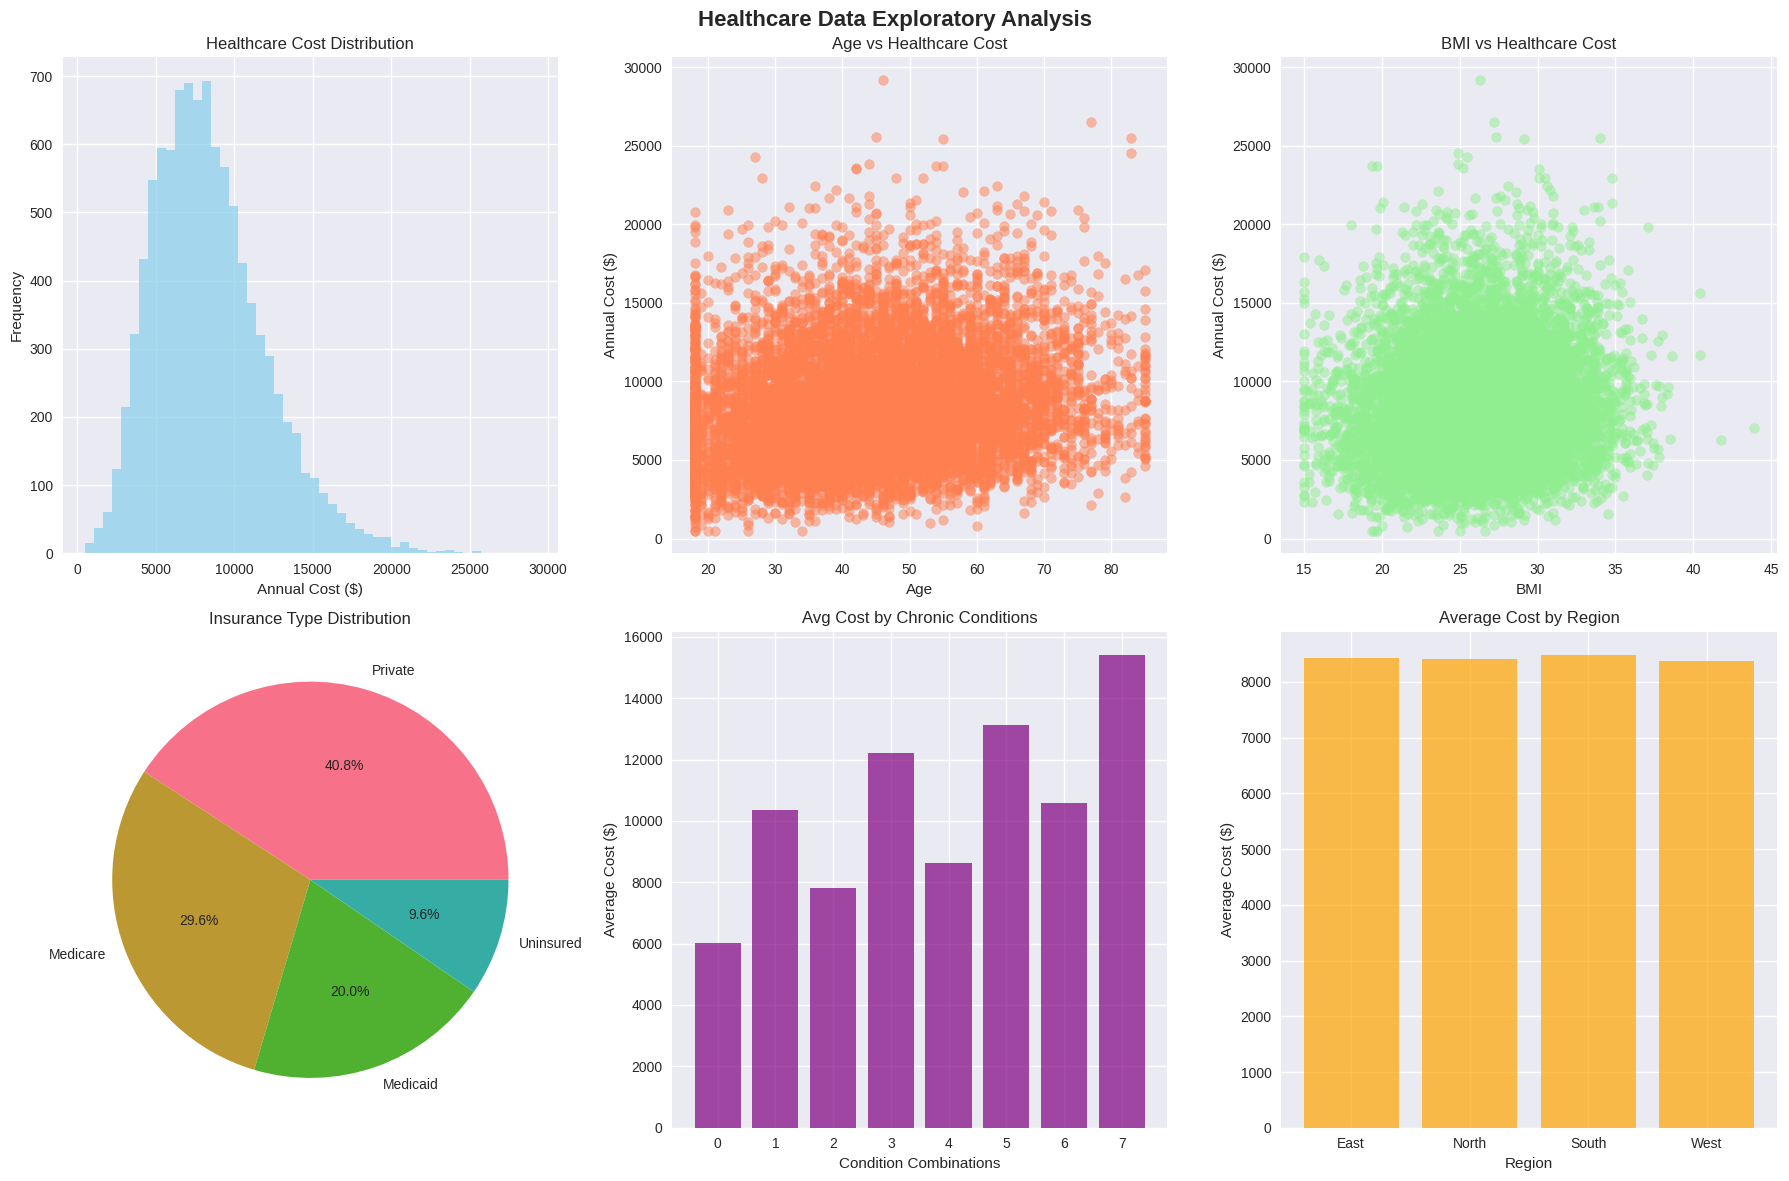


### 🔗 Correlation Analysis:


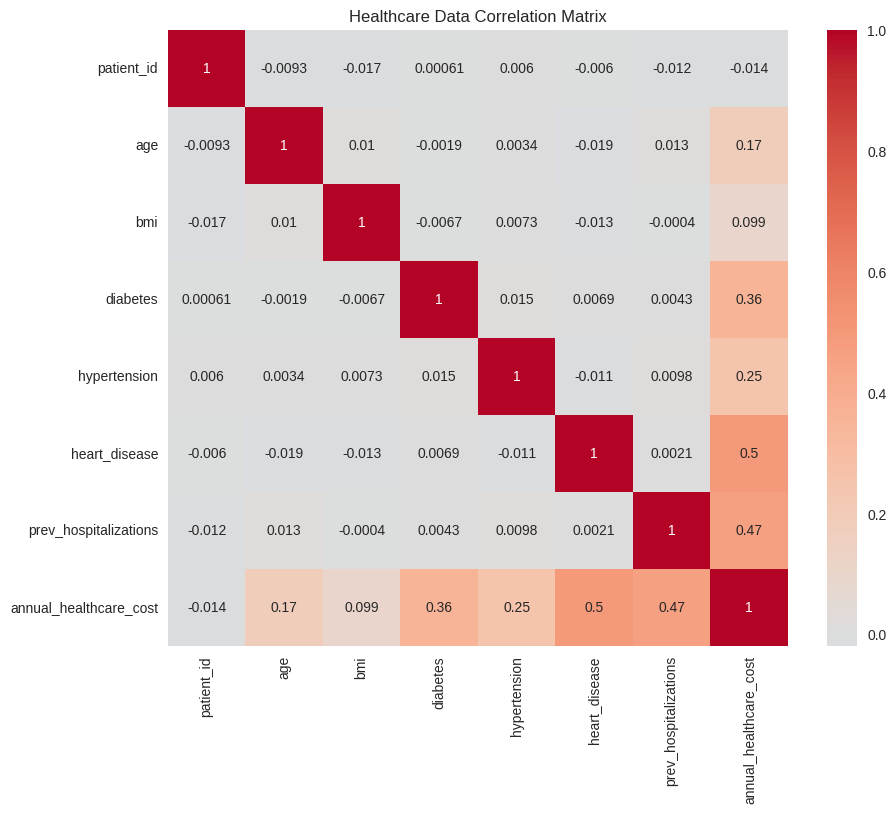

In [3]:
def perform_eda(df):
    """Comprehensive EDA for healthcare data"""

    print("## 📈 Healthcare Cost Distribution Analysis")

    # Basic statistics
    print("\n### Basic Statistics:")
    print(df.describe())

    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Healthcare Data Exploratory Analysis', fontsize=16, fontweight='bold')

    # Cost distribution
    axes[0,0].hist(df['annual_healthcare_cost'], bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Healthcare Cost Distribution')
    axes[0,0].set_xlabel('Annual Cost ($)')
    axes[0,0].set_ylabel('Frequency')

    # Age vs Cost
    axes[0,1].scatter(df['age'], df['annual_healthcare_cost'], alpha=0.5, color='coral')
    axes[0,1].set_title('Age vs Healthcare Cost')
    axes[0,1].set_xlabel('Age')
    axes[0,1].set_ylabel('Annual Cost ($)')

    # BMI vs Cost
    axes[0,2].scatter(df['bmi'], df['annual_healthcare_cost'], alpha=0.5, color='lightgreen')
    axes[0,2].set_title('BMI vs Healthcare Cost')
    axes[0,2].set_xlabel('BMI')
    axes[0,2].set_ylabel('Annual Cost ($)')

    # Insurance type distribution
    insurance_counts = df['insurance_type'].value_counts()
    axes[1,0].pie(insurance_counts.values, labels=insurance_counts.index, autopct='%1.1f%%')
    axes[1,0].set_title('Insurance Type Distribution')

    # Cost by chronic conditions
    chronic_data = df.groupby(['diabetes', 'hypertension', 'heart_disease'])['annual_healthcare_cost'].mean()
    axes[1,1].bar(range(len(chronic_data)), chronic_data.values, color='purple', alpha=0.7)
    axes[1,1].set_title('Avg Cost by Chronic Conditions')
    axes[1,1].set_xlabel('Condition Combinations')
    axes[1,1].set_ylabel('Average Cost ($)')

    # Cost by region
    region_costs = df.groupby('region')['annual_healthcare_cost'].mean()
    axes[1,2].bar(region_costs.index, region_costs.values, color='orange', alpha=0.7)
    axes[1,2].set_title('Average Cost by Region')
    axes[1,2].set_xlabel('Region')
    axes[1,2].set_ylabel('Average Cost ($)')

    plt.tight_layout()
    plt.show()

    # Correlation analysis
    print("\n### 🔗 Correlation Analysis:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Healthcare Data Correlation Matrix')
    plt.show()

    return correlation_matrix

# Perform EDA
correlation_matrix = perform_eda(healthcare_df)

In [4]:
class HealthcareCostPredictor:
    """Healthcare Cost Prediction Model"""

    def __init__(self):
        self.models = {}
        self.scalers = {}
        self.encoders = {}
        self.feature_names = None

    def preprocess_data(self, df):
        """Preprocess the healthcare data"""
        df_processed = df.copy()

        # Encode categorical variables
        categorical_cols = ['gender', 'insurance_type', 'region']

        for col in categorical_cols:
            if col not in self.encoders:
                self.encoders[col] = LabelEncoder()
                df_processed[col] = self.encoders[col].fit_transform(df_processed[col])
            else:
                df_processed[col] = self.encoders[col].transform(df_processed[col])

        # Feature engineering
        df_processed['age_bmi_interaction'] = df_processed['age'] * df_processed['bmi']
        df_processed['total_chronic_conditions'] = (df_processed['diabetes'] +
                                                   df_processed['hypertension'] +
                                                   df_processed['heart_disease'])
        df_processed['high_risk'] = ((df_processed['age'] > 60) |
                                   (df_processed['total_chronic_conditions'] >= 2)).astype(int)

        return df_processed

    def train_models(self, df):
        """Train multiple ML models"""

        # Preprocess data
        df_processed = self.preprocess_data(df)

        # Prepare features and target
        feature_cols = [col for col in df_processed.columns
                       if col not in ['patient_id', 'annual_healthcare_cost']]

        X = df_processed[feature_cols]
        y = df_processed['annual_healthcare_cost']

        self.feature_names = feature_cols

        # Train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features
        self.scalers['standard'] = StandardScaler()
        X_train_scaled = self.scalers['standard'].fit_transform(X_train)
        X_test_scaled = self.scalers['standard'].transform(X_test)

        # Model 1: Random Forest
        print("🌲 Training Random Forest Model...")
        rf_params = {
            'n_estimators': [100, 200],
            'max_depth': [10, 15, 20],
            'min_samples_split': [5, 10]
        }

        rf = RandomForestRegressor(random_state=42)
        rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        rf_grid.fit(X_train, y_train)

        self.models['random_forest'] = rf_grid.best_estimator_

        # Model 2: XGBoost
        print("🚀 Training XGBoost Model...")
        xgb_params = {
            'n_estimators': [100, 200],
            'max_depth': [6, 8, 10],
            'learning_rate': [0.1, 0.2]
        }

        xgb_model = xgb.XGBRegressor(random_state=42)
        xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        xgb_grid.fit(X_train, y_train)

        self.models['xgboost'] = xgb_grid.best_estimator_

        # Evaluate models
        self.evaluation_results = self.evaluate_models(X_test, y_test)

        print("✅ Model training completed!")
        return self.evaluation_results

    def evaluate_models(self, X_test, y_test):
        """Evaluate trained models"""
        results = {}

        for name, model in self.models.items():
            y_pred = model.predict(X_test)

            results[name] = {
                'mse': mean_squared_error(y_test, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                'mae': mean_absolute_error(y_test, y_pred),
                'r2': r2_score(y_test, y_pred)
            }

            print(f"\n📊 {name.upper()} Results:")
            print(f"RMSE: ${results[name]['rmse']:,.2f}")
            print(f"MAE: ${results[name]['mae']:,.2f}")
            print(f"R²: {results[name]['r2']:.4f}")

        return results

    def get_feature_importance(self, model_name='random_forest'):
        """Get feature importance"""
        if model_name in self.models:
            importance = self.models[model_name].feature_importances_
            feature_importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False)

            return feature_importance_df
        else:
            print(f"Model {model_name} not found!")
            return None

    def predict_cost(self, patient_data):
        """Predict healthcare cost for new patients"""
        if not self.models:
            print("⚠️ No trained models found!")
            return None

        # Use the best performing model (you can modify this logic)
        best_model = self.models['xgboost']  # Assuming XGBoost performs better

        # Preprocess the input data
        processed_data = self.preprocess_data(patient_data)
        X = processed_data[self.feature_names]

        # Make prediction
        prediction = best_model.predict(X)

        return prediction

# Initialize and train the model
predictor = HealthcareCostPredictor()
evaluation_results = predictor.train_models(healthcare_df)

🌲 Training Random Forest Model...
🚀 Training XGBoost Model...

📊 RANDOM_FOREST Results:
RMSE: $1,081.03
MAE: $859.61
R²: 0.9087

📊 XGBOOST Results:
RMSE: $1,054.71
MAE: $836.61
R²: 0.9130
✅ Model training completed!


In [5]:
class RiskStratification:
    """Patient Risk Stratification System"""

    def __init__(self, predictor_model):
        self.predictor = predictor_model
        self.risk_thresholds = {
            'low': 5000,
            'medium': 15000,
            'high': 25000
        }

    def stratify_patients(self, df):
        """Stratify patients into risk categories"""

        # Get predictions
        df_processed = self.predictor.preprocess_data(df)
        X = df_processed[self.predictor.feature_names]
        predicted_costs = self.predictor.models['xgboost'].predict(X)

        # Create risk categories
        risk_categories = []
        for cost in predicted_costs:
            if cost < self.risk_thresholds['low']:
                risk_categories.append('Low Risk')
            elif cost < self.risk_thresholds['medium']:
                risk_categories.append('Medium Risk')
            elif cost < self.risk_thresholds['high']:
                risk_categories.append('High Risk')
            else:
                risk_categories.append('Critical Risk')

        # Create comprehensive risk DataFrame
        risk_df = df.copy()
        risk_df['predicted_cost'] = predicted_costs
        risk_df['risk_category'] = risk_categories
        risk_df['cost_difference'] = risk_df['predicted_cost'] - risk_df['annual_healthcare_cost']

        return risk_df

    def generate_risk_report(self, risk_df):
        """Generate comprehensive risk analysis report"""

        print("## 🎯 Patient Risk Stratification Report")
        print("=" * 50)

        # Risk distribution
        risk_counts = risk_df['risk_category'].value_counts()
        print("\n### Risk Category Distribution:")
        for category, count in risk_counts.items():
            percentage = (count / len(risk_df)) * 100
            print(f"  {category}: {count} patients ({percentage:.1f}%)")

        # Average costs by risk category
        print("\n### Average Costs by Risk Category:")
        avg_costs = risk_df.groupby('risk_category')['predicted_cost'].mean()
        for category, cost in avg_costs.items():
            print(f"  {category}: ${cost:,.2f}")

        # High-risk patient characteristics
        high_risk_patients = risk_df[risk_df['risk_category'].isin(['High Risk', 'Critical Risk'])]
        print(f"\n### High-Risk Patients Analysis ({len(high_risk_patients)} patients):")
        print(f"  Average Age: {high_risk_patients['age'].mean():.1f} years")
        print(f"  Average BMI: {high_risk_patients['bmi'].mean():.1f}")
        print(f"  Diabetes Rate: {(high_risk_patients['diabetes'].sum() / len(high_risk_patients) * 100):.1f}%")
        print(f"  Hypertension Rate: {(high_risk_patients['hypertension'].sum() / len(high_risk_patients) * 100):.1f}%")
        print(f"  Heart Disease Rate: {(high_risk_patients['heart_disease'].sum() / len(high_risk_patients) * 100):.1f}%")

        return risk_df

    def visualize_risk_stratification(self, risk_df):
        """Create visualizations for risk stratification"""

        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Risk Category Distribution', 'Cost by Risk Category',
                          'Age Distribution by Risk', 'Chronic Conditions by Risk'),
            specs=[[{"type": "pie"}, {"type": "bar"}],
                   [{"type": "box"}, {"type": "bar"}]]
        )

        # Risk category pie chart
        risk_counts = risk_df['risk_category'].value_counts()
        fig.add_trace(
            go.Pie(labels=risk_counts.index, values=risk_counts.values, name="Risk Distribution"),
            row=1, col=1
        )

        # Average cost by risk category
        avg_costs = risk_df.groupby('risk_category')['predicted_cost'].mean()
        fig.add_trace(
            go.Bar(x=avg_costs.index, y=avg_costs.values, name="Average Cost"),
            row=1, col=2
        )

        # Age distribution by risk
        for category in risk_df['risk_category'].unique():
            subset = risk_df[risk_df['risk_category'] == category]
            fig.add_trace(
                go.Box(y=subset['age'], name=category),
                row=2, col=1
            )

        # Chronic conditions by risk
        chronic_by_risk = risk_df.groupby('risk_category')[['diabetes', 'hypertension', 'heart_disease']].mean()
        for condition in ['diabetes', 'hypertension', 'heart_disease']:
            fig.add_trace(
                go.Bar(x=chronic_by_risk.index, y=chronic_by_risk[condition], name=condition),
                row=2, col=2
            )

        fig.update_layout(height=800, showlegend=True, title_text="Healthcare Risk Stratification Dashboard")
        fig.show()

# Create risk stratification
risk_system = RiskStratification(predictor)
risk_df = risk_system.stratify_patients(healthcare_df)
risk_report = risk_system.generate_risk_report(risk_df)
risk_system.visualize_risk_stratification(risk_df)

## 🎯 Patient Risk Stratification Report

### Risk Category Distribution:
  Medium Risk: 8034 patients (80.3%)
  Low Risk: 1513 patients (15.1%)
  High Risk: 451 patients (4.5%)
  Critical Risk: 2 patients (0.0%)

### Average Costs by Risk Category:
  Critical Risk: $25,836.73
  High Risk: $17,368.40
  Low Risk: $4,036.71
  Medium Risk: $8,741.96

### High-Risk Patients Analysis (453 patients):
  Average Age: 48.8 years
  Average BMI: 26.5
  Diabetes Rate: 64.0%
  Hypertension Rate: 61.1%
  Heart Disease Rate: 73.7%


## 🎯 Resource Allocation Optimization

### Optimized Resource Allocation:
               patient_count      avg_cost    total_cost  avg_age  \
risk_category                                                       
Critical Risk              2  25836.730469  5.167346e+04    80.00   
High Risk                451  17368.400391  7.833150e+06    48.67   
Low Risk                1513   4036.709961  6.107538e+06    39.17   
Medium Risk             8034   8741.959961  7.023293e+07    45.50   

               avg_hospitalizations  resource_weight  weighted_patients  \
risk_category                                                             
Critical Risk                  4.00              5.0               10.0   
High Risk                      2.69              3.5             1578.5   
Low Risk                       0.53              1.0             1513.0   
Medium Risk                    1.60              2.0            16068.0   

               doctors_allocated  nurses_allocated  beds_all

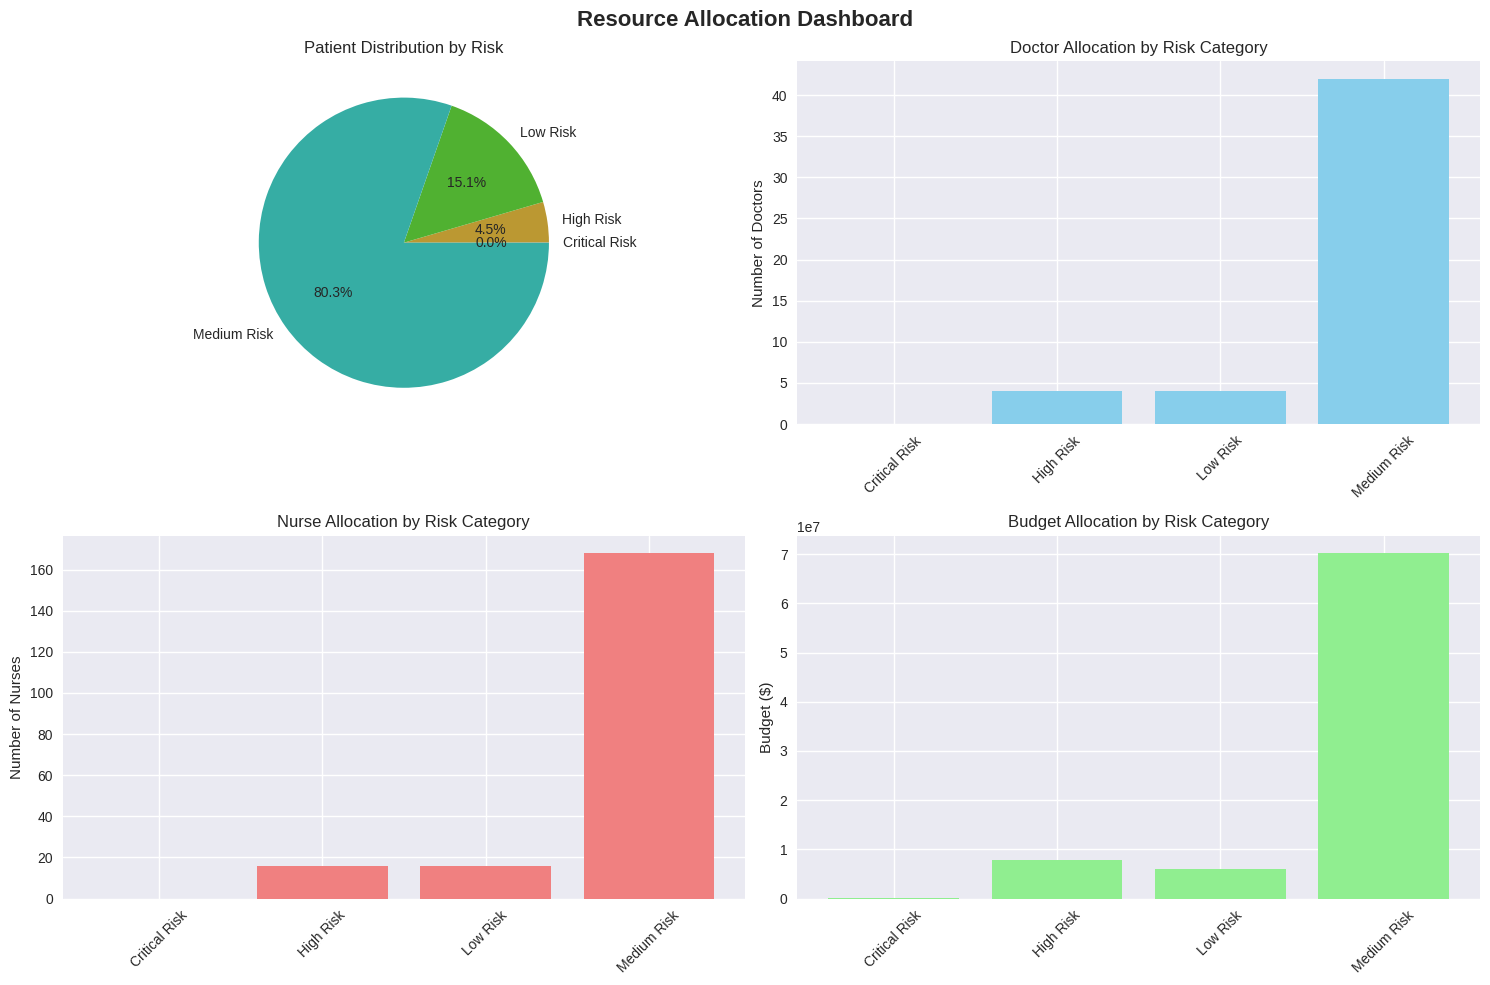


## 💰 ROI Analysis for Treatment Interventions

### Preventive Care Program:
  Target Patients: 8,485
  Intervention Cost: $4,242,500.00
  Potential Savings: $11,709,912.00
  Net Benefit: $7,467,412.00
  ROI: 176.0%

### Chronic Disease Management:
  Target Patients: 453
  Intervention Cost: $543,600.00
  Potential Savings: $1,971,205.88
  Net Benefit: $1,427,605.88
  ROI: 262.6%

### Wellness Program:
  Target Patients: 9,547
  Intervention Cost: $1,909,400.00
  Potential Savings: $6,107,237.00
  Net Benefit: $4,197,837.00
  ROI: 219.9%


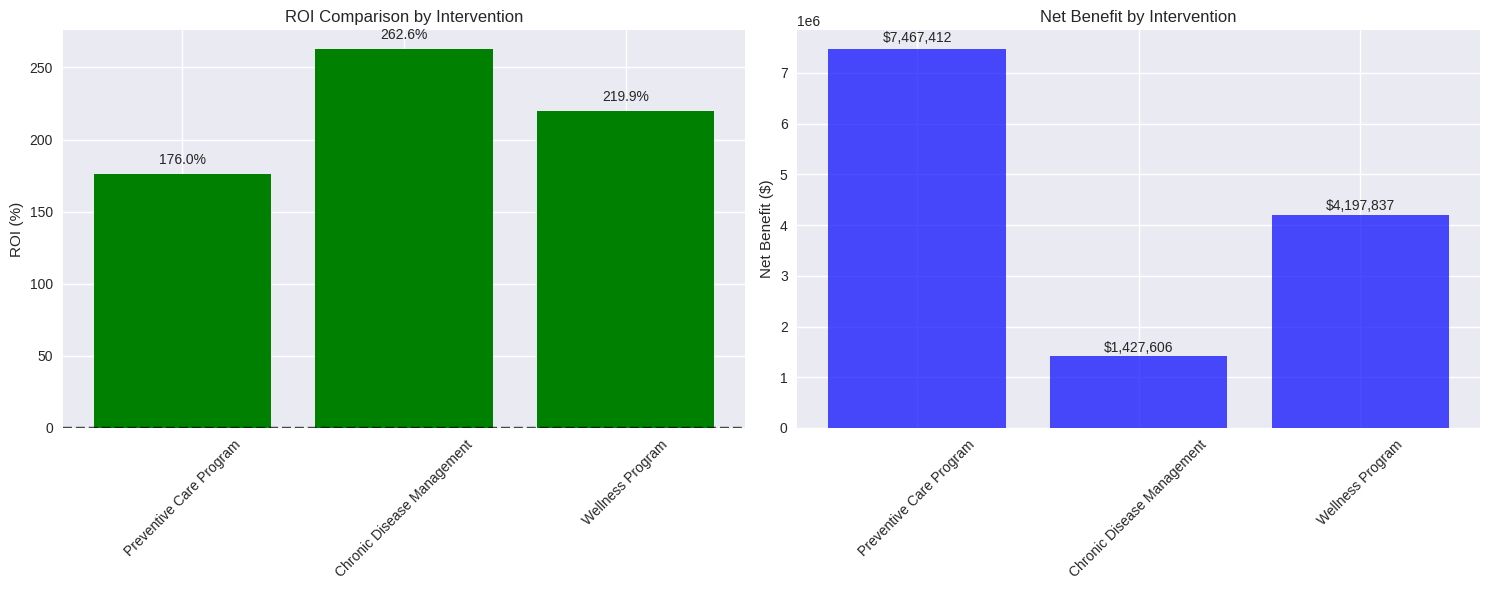

In [6]:
class ResourceOptimization:
    """Healthcare Resource Allocation Optimization System"""

    def __init__(self, risk_df):
        self.risk_df = risk_df
        self.resource_constraints = {
            'doctors': 50,
            'nurses': 200,
            'beds': 300,
            'budget': 5000000  # $5M annual budget
        }

    def optimize_resource_allocation(self):
        """Optimize resource allocation based on patient risk"""

        print("## 🎯 Resource Allocation Optimization")
        print("=" * 50)

        # Calculate resource needs by risk category
        risk_summary = self.risk_df.groupby('risk_category').agg({
            'patient_id': 'count',
            'predicted_cost': ['mean', 'sum'],
            'age': 'mean',
            'prev_hospitalizations': 'mean'
        }).round(2)

        risk_summary.columns = ['patient_count', 'avg_cost', 'total_cost', 'avg_age', 'avg_hospitalizations']

        # Resource allocation weights (higher for high-risk patients)
        allocation_weights = {
            'Low Risk': 1.0,
            'Medium Risk': 2.0,
            'High Risk': 3.5,
            'Critical Risk': 5.0
        }

        # Calculate weighted resource needs
        risk_summary['resource_weight'] = risk_summary.index.map(allocation_weights)
        risk_summary['weighted_patients'] = risk_summary['patient_count'] * risk_summary['resource_weight']

        total_weighted = risk_summary['weighted_patients'].sum()

        # Allocate resources proportionally
        for resource, total_available in self.resource_constraints.items():
            if resource != 'budget':
                risk_summary[f'{resource}_allocated'] = (
                    risk_summary['weighted_patients'] / total_weighted * total_available
                ).round()

        # Budget allocation
        risk_summary['budget_allocated'] = risk_summary['total_cost']

        print("\n### Optimized Resource Allocation:")
        print(risk_summary)

        # Visualization
        self.visualize_resource_allocation(risk_summary)

        return risk_summary

    def calculate_roi_analysis(self):
        """Calculate ROI for different treatment interventions"""

        print("\n## 💰 ROI Analysis for Treatment Interventions")
        print("=" * 50)

        # Define intervention scenarios
        interventions = {
            'Preventive Care Program': {
                'cost_per_patient': 500,
                'cost_reduction': 0.15,  # 15% cost reduction
                'target_risk': ['Medium Risk', 'High Risk']
            },
            'Chronic Disease Management': {
                'cost_per_patient': 1200,
                'cost_reduction': 0.25,  # 25% cost reduction
                'target_risk': ['High Risk', 'Critical Risk']
            },
            'Wellness Program': {
                'cost_per_patient': 200,
                'cost_reduction': 0.08,  # 8% cost reduction
                'target_risk': ['Low Risk', 'Medium Risk']
            }
        }

        roi_results = {}

        for intervention_name, params in interventions.items():
            # Filter target patients
            target_patients = self.risk_df[
                self.risk_df['risk_category'].isin(params['target_risk'])
            ]

            # Calculate costs and savings
            intervention_cost = len(target_patients) * params['cost_per_patient']
            current_total_cost = target_patients['predicted_cost'].sum()
            potential_savings = current_total_cost * params['cost_reduction']
            net_benefit = potential_savings - intervention_cost
            roi_percentage = (net_benefit / intervention_cost) * 100 if intervention_cost > 0 else 0

            roi_results[intervention_name] = {
                'target_patients': len(target_patients),
                'intervention_cost': intervention_cost,
                'potential_savings': potential_savings,
                'net_benefit': net_benefit,
                'roi_percentage': roi_percentage
            }

            print(f"\n### {intervention_name}:")
            print(f"  Target Patients: {len(target_patients):,}")
            print(f"  Intervention Cost: ${intervention_cost:,.2f}")
            print(f"  Potential Savings: ${potential_savings:,.2f}")
            print(f"  Net Benefit: ${net_benefit:,.2f}")
            print(f"  ROI: {roi_percentage:.1f}%")

        # Visualize ROI analysis
        self.visualize_roi_analysis(roi_results)

        return roi_results

    def visualize_resource_allocation(self, risk_summary):
        """Visualize resource allocation"""

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Resource Allocation Dashboard', fontsize=16, fontweight='bold')

        # Patient distribution
        axes[0,0].pie(risk_summary['patient_count'], labels=risk_summary.index, autopct='%1.1f%%')
        axes[0,0].set_title('Patient Distribution by Risk')

        # Doctor allocation
        axes[0,1].bar(risk_summary.index, risk_summary['doctors_allocated'], color='skyblue')
        axes[0,1].set_title('Doctor Allocation by Risk Category')
        axes[0,1].set_ylabel('Number of Doctors')
        axes[0,1].tick_params(axis='x', rotation=45)

        # Nurse allocation
        axes[1,0].bar(risk_summary.index, risk_summary['nurses_allocated'], color='lightcoral')
        axes[1,0].set_title('Nurse Allocation by Risk Category')
        axes[1,0].set_ylabel('Number of Nurses')
        axes[1,0].tick_params(axis='x', rotation=45)

        # Budget allocation
        axes[1,1].bar(risk_summary.index, risk_summary['budget_allocated'], color='lightgreen')
        axes[1,1].set_title('Budget Allocation by Risk Category')
        axes[1,1].set_ylabel('Budget ($)')
        axes[1,1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def visualize_roi_analysis(self, roi_results):
        """Visualize ROI analysis"""

        # Prepare data for visualization
        interventions = list(roi_results.keys())
        roi_values = [roi_results[intervention]['roi_percentage'] for intervention in interventions]
        net_benefits = [roi_results[intervention]['net_benefit'] for intervention in interventions]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # ROI comparison
        bars1 = ax1.bar(interventions, roi_values, color=['green' if x > 0 else 'red' for x in roi_values])
        ax1.set_title('ROI Comparison by Intervention')
        ax1.set_ylabel('ROI (%)')
        ax1.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        ax1.tick_params(axis='x', rotation=45)

        # Add value labels on bars
        for bar, value in zip(bars1, roi_values):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + (5 if height > 0 else -15),
                    f'{value:.1f}%', ha='center', va='bottom' if height > 0 else 'top')

        # Net benefit comparison
        bars2 = ax2.bar(interventions, net_benefits, color='blue', alpha=0.7)
        ax2.set_title('Net Benefit by Intervention')
        ax2.set_ylabel('Net Benefit ($)')
        ax2.tick_params(axis='x', rotation=45)

        # Add value labels
        for bar, value in zip(bars2, net_benefits):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + (height * 0.01),
                    f'${value:,.0f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

# Create resource optimization system
resource_optimizer = ResourceOptimization(risk_df)
resource_allocation = resource_optimizer.optimize_resource_allocation()
roi_analysis = resource_optimizer.calculate_roi_analysis()

## 📊 Executive Summary Dashboard
🏥 **Total Patients**: 10,000
💰 **Total Predicted Healthcare Costs**: $84,225,288.00
📈 **Average Cost per Patient**: $8,422.53
⚠️ **High-Risk Patients**: 4.5%



## 🎯 Intervention Impact Simulator

### Baseline (No Intervention):
  Total Healthcare Cost: $84,225,288.00
  Cost Savings: $0.00
  Implementation Cost: $0.00
  Net Savings: $0.00

### Basic Wellness Program:
  Total Healthcare Cost: $80,014,024.00
  Cost Savings: $4,211,264.00
  Implementation Cost: $50,000.00
  Net Savings: $4,161,264.00
  ROI: 8322.5%

### Comprehensive Prevention:
  Total Healthcare Cost: $71,591,496.00
  Cost Savings: $12,633,792.00
  Implementation Cost: $200,000.00
  Net Savings: $12,433,792.00
  ROI: 6216.9%

### Targeted High-Risk Management:
  Total Healthcare Cost: $63,168,968.00
  Cost Savings: $21,056,320.00
  Implementation Cost: $500,000.00
  Net Savings: $20,556,320.00
  ROI: 4111.3%

### Full Digital Health Integration:
  Total Healthcare Cost: $54,746,436.00
  Cost Savings: $29,478,852.00
  Implementation Cost: $1,000,000.00
  Net Savings: $28,478,852.00
  ROI: 2847.9%


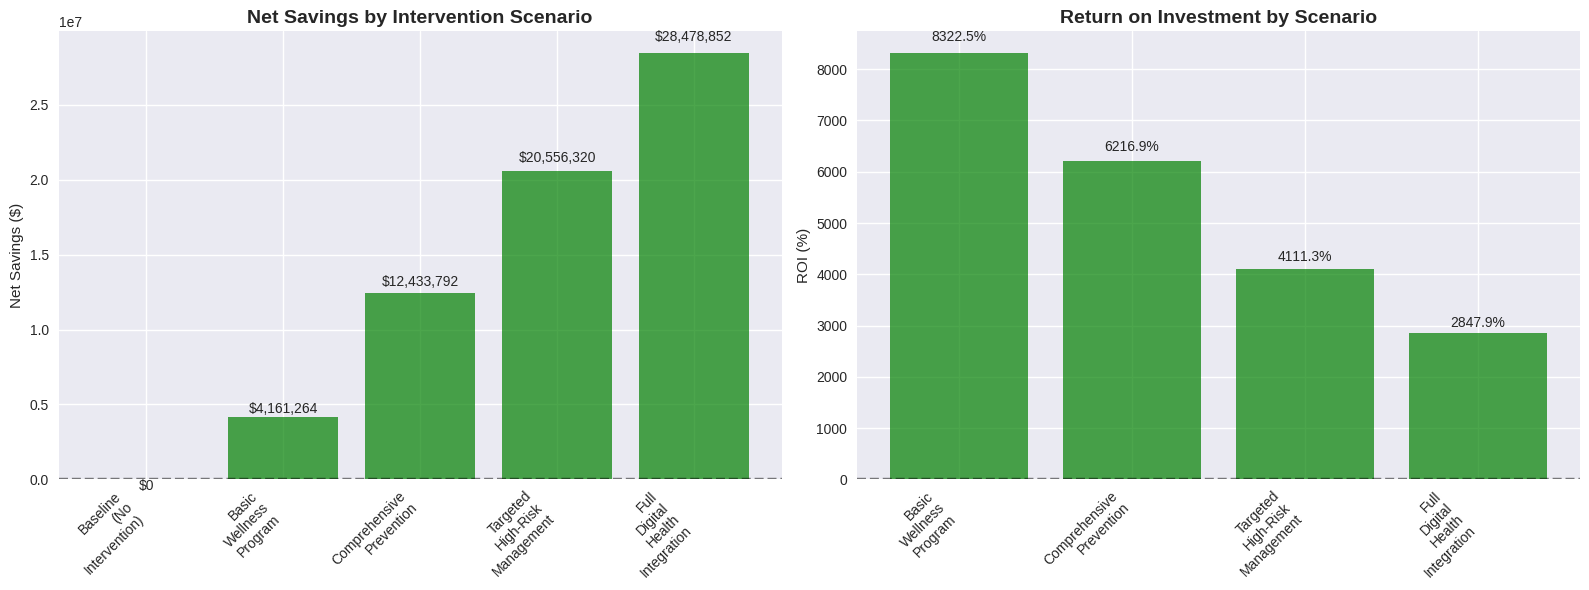


## 🤖 Predictive Model Performance Dashboard


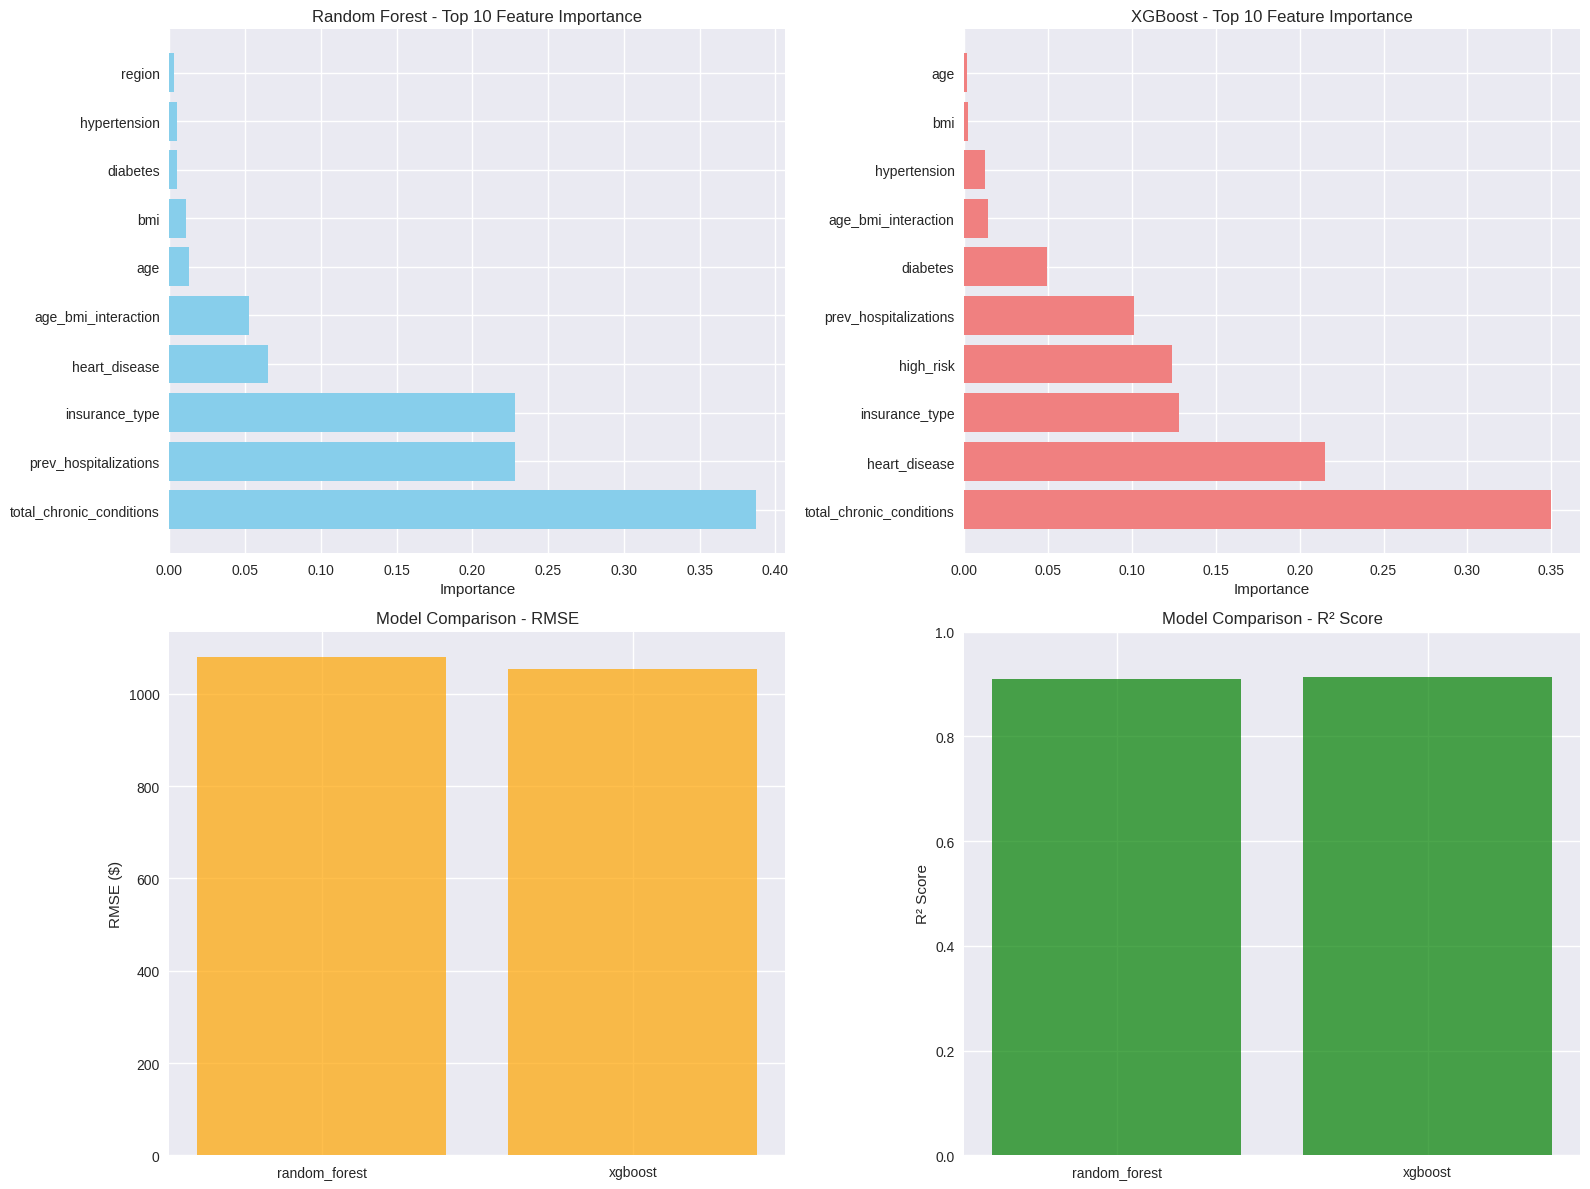

In [7]:
class HealthcareDashboard:
    """Interactive Healthcare Analytics Dashboard"""

    def __init__(self, risk_df, predictor):
        self.risk_df = risk_df
        self.predictor = predictor

    def create_executive_summary(self):
        """Create executive summary dashboard"""

        # Key metrics
        total_patients = len(self.risk_df)
        total_predicted_cost = self.risk_df['predicted_cost'].sum()
        avg_cost_per_patient = self.risk_df['predicted_cost'].mean()
        high_risk_percentage = (len(self.risk_df[self.risk_df['risk_category'].isin(['High Risk', 'Critical Risk'])]) / total_patients) * 100

        print("## 📊 Executive Summary Dashboard")
        print("=" * 50)
        print(f"🏥 **Total Patients**: {total_patients:,}")
        print(f"💰 **Total Predicted Healthcare Costs**: ${total_predicted_cost:,.2f}")
        print(f"📈 **Average Cost per Patient**: ${avg_cost_per_patient:,.2f}")
        print(f"⚠️ **High-Risk Patients**: {high_risk_percentage:.1f}%")

        # Create interactive plots
        self.create_cost_trend_analysis()
        self.create_demographic_analysis()
        self.create_intervention_simulator()

    def create_cost_trend_analysis(self):
        """Create cost trend analysis"""

        # Cost by age groups
        age_groups = pd.cut(self.risk_df['age'], bins=[0, 30, 45, 60, 75, 100],
                           labels=['<30', '30-45', '45-60', '60-75', '75+'])
        cost_by_age = self.risk_df.groupby(age_groups)['predicted_cost'].mean()

        # Cost by BMI categories
        bmi_categories = pd.cut(self.risk_df['bmi'], bins=[0, 18.5, 25, 30, 50],
                              labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
        cost_by_bmi = self.risk_df.groupby(bmi_categories)['predicted_cost'].mean()

        # Create subplots
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Cost by Age Group', 'Cost by BMI Category',
                          'Cost Distribution by Insurance', 'Regional Cost Analysis'),
            specs=[[{"type": "bar"}, {"type": "bar"}],
                   [{"type": "box"}, {"type": "bar"}]]
        )

        # Age group analysis
        fig.add_trace(
            go.Bar(x=cost_by_age.index.astype(str), y=cost_by_age.values,
                  name="Cost by Age", marker_color='lightblue'),
            row=1, col=1
        )

                # BMI category analysis
        fig.add_trace(
            go.Bar(x=cost_by_bmi.index.astype(str), y=cost_by_bmi.values,
                  name="Cost by BMI", marker_color='lightcoral'),
            row=1, col=2
        )

        # Insurance type box plot
        for insurance_type in self.risk_df['insurance_type'].unique():
            subset = self.risk_df[self.risk_df['insurance_type'] == insurance_type]
            fig.add_trace(
                go.Box(y=subset['predicted_cost'], name=insurance_type),
                row=2, col=1
            )

        # Regional analysis
        regional_costs = self.risk_df.groupby('region')['predicted_cost'].mean()
        fig.add_trace(
            go.Bar(x=regional_costs.index, y=regional_costs.values,
                  name="Regional Costs", marker_color='lightgreen'),
            row=2, col=2
        )

        fig.update_layout(height=800, showlegend=False,
                         title_text="Healthcare Cost Trend Analysis Dashboard")
        fig.show()

    def create_demographic_analysis(self):
        """Create demographic analysis dashboard"""

        fig = make_subplots(
            rows=2, cols=3,
            subplot_titles=('Gender Distribution', 'Age Distribution', 'Chronic Disease Prevalence',
                          'Insurance Coverage', 'Hospitalization History', 'Risk vs Cost Correlation'),
            specs=[[{"type": "pie"}, {"type": "histogram"}, {"type": "bar"}],
                   [{"type": "pie"}, {"type": "histogram"}, {"type": "scatter"}]]
        )

        # Gender distribution
        gender_counts = self.risk_df['gender'].value_counts()
        fig.add_trace(
            go.Pie(labels=gender_counts.index, values=gender_counts.values, name="Gender"),
            row=1, col=1
        )

        # Age histogram
        fig.add_trace(
            go.Histogram(x=self.risk_df['age'], nbinsx=20, name="Age Distribution"),
            row=1, col=2
        )

        # Chronic disease prevalence
        chronic_conditions = ['diabetes', 'hypertension', 'heart_disease']
        prevalence = [self.risk_df[condition].sum() / len(self.risk_df) * 100 for condition in chronic_conditions]
        fig.add_trace(
            go.Bar(x=chronic_conditions, y=prevalence, name="Disease Prevalence"),
            row=1, col=3
        )

        # Insurance coverage
        insurance_counts = self.risk_df['insurance_type'].value_counts()
        fig.add_trace(
            go.Pie(labels=insurance_counts.index, values=insurance_counts.values, name="Insurance"),
            row=2, col=1
        )

        # Hospitalization history
        fig.add_trace(
            go.Histogram(x=self.risk_df['prev_hospitalizations'], nbinsx=10, name="Hospitalizations"),
            row=2, col=2
        )

        # Risk vs Cost scatter
        risk_mapping = {'Low Risk': 1, 'Medium Risk': 2, 'High Risk': 3, 'Critical Risk': 4}
        risk_numeric = self.risk_df['risk_category'].map(risk_mapping)
        fig.add_trace(
            go.Scatter(x=risk_numeric, y=self.risk_df['predicted_cost'],
                      mode='markers', name="Risk vs Cost", opacity=0.6),
            row=2, col=3
        )

        fig.update_layout(height=800, showlegend=False,
                         title_text="Healthcare Demographics Analysis Dashboard")
        fig.show()

    def create_intervention_simulator(self):
        """Create intervention impact simulator"""

        print("\n## 🎯 Intervention Impact Simulator")
        print("=" * 50)

        # Simulate different intervention scenarios
        scenarios = {
            'Baseline (No Intervention)': {'cost_reduction': 0, 'implementation_cost': 0},
            'Basic Wellness Program': {'cost_reduction': 0.05, 'implementation_cost': 50000},
            'Comprehensive Prevention': {'cost_reduction': 0.15, 'implementation_cost': 200000},
            'Targeted High-Risk Management': {'cost_reduction': 0.25, 'implementation_cost': 500000},
            'Full Digital Health Integration': {'cost_reduction': 0.35, 'implementation_cost': 1000000}
        }

        scenario_results = {}
        baseline_cost = self.risk_df['predicted_cost'].sum()

        for scenario_name, params in scenarios.items():
            reduced_cost = baseline_cost * (1 - params['cost_reduction'])
            total_savings = baseline_cost - reduced_cost
            net_savings = total_savings - params['implementation_cost']
            roi = (net_savings / params['implementation_cost'] * 100) if params['implementation_cost'] > 0 else 0

            scenario_results[scenario_name] = {
                'total_cost': reduced_cost,
                'savings': total_savings,
                'implementation_cost': params['implementation_cost'],
                'net_savings': net_savings,
                'roi': roi
            }

            print(f"\n### {scenario_name}:")
            print(f"  Total Healthcare Cost: ${reduced_cost:,.2f}")
            print(f"  Cost Savings: ${total_savings:,.2f}")
            print(f"  Implementation Cost: ${params['implementation_cost']:,.2f}")
            print(f"  Net Savings: ${net_savings:,.2f}")
            if params['implementation_cost'] > 0:
                print(f"  ROI: {roi:.1f}%")

        # Visualize scenarios
        self.visualize_intervention_scenarios(scenario_results)

        return scenario_results

    def visualize_intervention_scenarios(self, scenario_results):
        """Visualize intervention scenarios"""

        scenarios = list(scenario_results.keys())
        net_savings = [scenario_results[s]['net_savings'] for s in scenarios]
        roi_values = [scenario_results[s]['roi'] for s in scenarios]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Net savings comparison
        colors = ['red' if x < 0 else 'green' for x in net_savings]
        bars1 = ax1.bar(range(len(scenarios)), net_savings, color=colors, alpha=0.7)
        ax1.set_title('Net Savings by Intervention Scenario', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Net Savings ($)')
        ax1.set_xticks(range(len(scenarios)))
        ax1.set_xticklabels([s.replace(' ', '\n') for s in scenarios], rotation=45, ha='right')
        ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)

        # Add value labels
        for i, (bar, value) in enumerate(zip(bars1, net_savings)):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + (abs(height) * 0.02),
                    f'${value:,.0f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

        # ROI comparison (excluding baseline)
        roi_scenarios = scenarios[1:]  # Exclude baseline
        roi_vals = roi_values[1:]
        colors_roi = ['red' if x < 0 else 'green' for x in roi_vals]
        bars2 = ax2.bar(range(len(roi_scenarios)), roi_vals, color=colors_roi, alpha=0.7)
        ax2.set_title('Return on Investment by Scenario', fontsize=14, fontweight='bold')
        ax2.set_ylabel('ROI (%)')
        ax2.set_xticks(range(len(roi_scenarios)))
        ax2.set_xticklabels([s.replace(' ', '\n') for s in roi_scenarios], rotation=45, ha='right')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

        # Add value labels
        for bar, value in zip(bars2, roi_vals):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + (abs(height) * 0.02),
                    f'{value:.1f}%', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

        plt.tight_layout()
        plt.show()

    def create_predictive_model_dashboard(self):
        """Create model performance dashboard"""

        print("\n## 🤖 Predictive Model Performance Dashboard")
        print("=" * 50)

        # Feature importance analysis
        feature_importance = self.predictor.get_feature_importance('random_forest')
        feature_importance_xgb = self.predictor.get_feature_importance('xgboost')

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

        # Random Forest feature importance
        top_features_rf = feature_importance.head(10)
        ax1.barh(top_features_rf['feature'], top_features_rf['importance'], color='skyblue')
        ax1.set_title('Random Forest - Top 10 Feature Importance')
        ax1.set_xlabel('Importance')

        # XGBoost feature importance
        top_features_xgb = feature_importance_xgb.head(10)
        ax2.barh(top_features_xgb['feature'], top_features_xgb['importance'], color='lightcoral')
        ax2.set_title('XGBoost - Top 10 Feature Importance')
        ax2.set_xlabel('Importance')

        # Model comparison
        models = list(self.predictor.evaluation_results.keys())
        rmse_values = [self.predictor.evaluation_results[model]['rmse'] for model in models]
        r2_values = [self.predictor.evaluation_results[model]['r2'] for model in models]

        ax3.bar(models, rmse_values, color='orange', alpha=0.7)
        ax3.set_title('Model Comparison - RMSE')
        ax3.set_ylabel('RMSE ($)')

        ax4.bar(models, r2_values, color='green', alpha=0.7)
        ax4.set_title('Model Comparison - R² Score')
        ax4.set_ylabel('R² Score')
        ax4.set_ylim(0, 1)

        plt.tight_layout()
        plt.show()

# Create comprehensive dashboard
dashboard = HealthcareDashboard(risk_df, predictor)
dashboard.create_executive_summary()
dashboard.create_predictive_model_dashboard()

In [8]:
class DatabaseManager:
    """Database management for healthcare system"""

    def __init__(self):
        self.connection_params = {
            'host': 'localhost',  # Update with your MySQL host
            'user': 'your_username',  # Update with your MySQL username
            'password': 'your_password',  # Update with your MySQL password
            'database': 'healthcare_db'
        }

    def create_database_schema(self):
        """Create database tables for healthcare system"""

        # For demonstration, we'll create the SQL schema
        schema_sql = """
        -- Healthcare Database Schema

        CREATE DATABASE IF NOT EXISTS healthcare_db;
        USE healthcare_db;

        -- Patients table
        CREATE TABLE IF NOT EXISTS patients (
            patient_id INT PRIMARY KEY,
            age INT NOT NULL,
            gender ENUM('Male', 'Female') NOT NULL,
            bmi DECIMAL(5,2) NOT NULL,
            diabetes BOOLEAN DEFAULT FALSE,
            hypertension BOOLEAN DEFAULT FALSE,
            heart_disease BOOLEAN DEFAULT FALSE,
            insurance_type ENUM('Medicare', 'Medicaid', 'Private', 'Uninsured') NOT NULL,
            region ENUM('North', 'South', 'East', 'West') NOT NULL,
            prev_hospitalizations INT DEFAULT 0,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );

        -- Cost predictions table
        CREATE TABLE IF NOT EXISTS cost_predictions (
            prediction_id INT AUTO_INCREMENT PRIMARY KEY,
            patient_id INT,
            predicted_cost DECIMAL(10,2) NOT NULL,
            actual_cost DECIMAL(10,2),
            risk_category ENUM('Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk') NOT NULL,
            prediction_date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
            model_version VARCHAR(50),
            FOREIGN KEY (patient_id) REFERENCES patients(patient_id)
        );

        -- Resource allocation table
        CREATE TABLE IF NOT EXISTS resource_allocation (
            allocation_id INT AUTO_INCREMENT PRIMARY KEY,
            risk_category ENUM('Low Risk', 'Medium Risk', 'High Risk', 'Critical Risk') NOT NULL,
            doctors_allocated INT,
            nurses_allocated INT,
            beds_allocated INT,
            budget_allocated DECIMAL(12,2),
            allocation_date DATE,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );

        -- Treatment interventions table
        CREATE TABLE IF NOT EXISTS interventions (
            intervention_id INT AUTO_INCREMENT PRIMARY KEY,
            intervention_name VARCHAR(100) NOT NULL,
            target_risk_categories JSON,
            cost_per_patient DECIMAL(8,2),
            expected_cost_reduction DECIMAL(3,2),
            roi_percentage DECIMAL(5,2),
            implementation_date DATE,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );

        -- Patient outcomes table
        CREATE TABLE IF NOT EXISTS patient_outcomes (
            outcome_id INT AUTO_INCREMENT PRIMARY KEY,
            patient_id INT,
            intervention_id INT,
            pre_intervention_cost DECIMAL(10,2),
            post_intervention_cost DECIMAL(10,2),
            outcome_date DATE,
            satisfaction_score INT CHECK (satisfaction_score BETWEEN 1 AND 10),
            FOREIGN KEY (patient_id) REFERENCES patients(patient_id),
            FOREIGN KEY (intervention_id) REFERENCES interventions(intervention_id)
        );
        """

        print("## 🗄️ Database Schema")
        print("=" * 50)
        print("```sql")
        print(schema_sql)
        print("```")

        return schema_sql

    def export_to_csv_for_powerbi(self, risk_df, resource_allocation, roi_analysis):
        """Export data to CSV files for Power BI integration"""

        print("\n## 📊 Exporting Data for Power BI Integration")
        print("=" * 50)

        # 1. Patient data with predictions
        patient_export = risk_df[['patient_id', 'age', 'gender', 'bmi', 'diabetes',
                                 'hypertension', 'heart_disease', 'insurance_type',
                                 'region', 'prev_hospitalizations', 'annual_healthcare_cost',
                                 'predicted_cost', 'risk_category']].copy()

        patient_export.to_csv('patient_data_with_predictions.csv', index=False)
        print("✅ Exported: patient_data_with_predictions.csv")

        # 2. Resource allocation data
        resource_df = pd.DataFrame(resource_allocation).T
        resource_df.reset_index(inplace=True)
        resource_df.rename(columns={'index': 'risk_category'}, inplace=True)
        resource_df.to_csv('resource_allocation.csv', index=False)
        print("✅ Exported: resource_allocation.csv")

        # 3. ROI analysis data
        roi_df = pd.DataFrame(roi_analysis).T
        roi_df.reset_index(inplace=True)
        roi_df.rename(columns={'index': 'intervention_name'}, inplace=True)
        roi_df.to_csv('roi_analysis.csv', index=False)
        print("✅ Exported: roi_analysis.csv")

        # 4. Summary metrics for dashboard
        summary_metrics = {
            'total_patients': len(risk_df),
            'total_predicted_cost': risk_df['predicted_cost'].sum(),
            'average_cost_per_patient': risk_df['predicted_cost'].mean(),
            'high_risk_patients': len(risk_df[risk_df['risk_category'].isin(['High Risk', 'Critical Risk'])]),
            'high_risk_percentage': len(risk_df[risk_df['risk_category'].isin(['High Risk', 'Critical Risk'])]) / len(risk_df) * 100,
            'model_accuracy_rf': predictor.evaluation_results['random_forest']['r2'],
            'model_accuracy_xgb': predictor.evaluation_results['xgboost']['r2']
        }

        summary_df = pd.DataFrame([summary_metrics])
        summary_df.to_csv('summary_metrics.csv', index=False)
        print("✅ Exported: summary_metrics.csv")

        # 5. Feature importance data
        feature_importance = predictor.get_feature_importance('xgboost')
        feature_importance.to_csv('feature_importance.csv', index=False)
        print("✅ Exported: feature_importance.csv")

        print(f"\n📁 **Total files exported**: 5")
        print("🔗 **Ready for Power BI import**")

        return {
            'patient_data': 'patient_data_with_predictions.csv',
            'resource_allocation': 'resource_allocation.csv',
            'roi_analysis': 'roi_analysis.csv',
            'summary_metrics': 'summary_metrics.csv',
            'feature_importance': 'feature_importance.csv'
        }

# Initialize database manager and export data
db_manager = DatabaseManager()
schema = db_manager.create_database_schema()
exported_files = db_manager.export_to_csv_for_powerbi(risk_df, resource_allocation, roi_analysis)

## 🗄️ Database Schema
```sql

        -- Healthcare Database Schema
        
        CREATE DATABASE IF NOT EXISTS healthcare_db;
        USE healthcare_db;
        
        -- Patients table
        CREATE TABLE IF NOT EXISTS patients (
            patient_id INT PRIMARY KEY,
            age INT NOT NULL,
            gender ENUM('Male', 'Female') NOT NULL,
            bmi DECIMAL(5,2) NOT NULL,
            diabetes BOOLEAN DEFAULT FALSE,
            hypertension BOOLEAN DEFAULT FALSE,
            heart_disease BOOLEAN DEFAULT FALSE,
            insurance_type ENUM('Medicare', 'Medicaid', 'Private', 'Uninsured') NOT NULL,
            region ENUM('North', 'South', 'East', 'West') NOT NULL,
            prev_hospitalizations INT DEFAULT 0,
            created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
        );
        
        -- Cost predictions table
        CREATE TABLE IF NOT EXISTS cost_predictions (
            prediction_id INT AUTO_INCREMENT PRIMARY KEY,
            patient_id INT,


In [9]:
from google.colab import files

# List of files to download
file_names = [
    'patient_data_with_predictions.csv',
    'resource_allocation.csv',
    'roi_analysis.csv',
    'summary_metrics.csv',
    'feature_importance.csv'
]

for file_name in file_names:
    try:
        files.download(file_name)
        print(f"Downloaded: {file_name}")
    except FileNotFoundError:
        print(f"Error: {file_name} not found. Make sure the file was created correctly.")
    except Exception as e:
        print(f"An error occurred while downloading {file_name}: {e}")

print("\nAll download attempts complete.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: patient_data_with_predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: resource_allocation.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: roi_analysis.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: summary_metrics.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: feature_importance.csv

All download attempts complete.


In [10]:
class HealthcareCostAPI:
    """API for healthcare cost prediction"""

    def __init__(self, predictor):
        self.predictor = predictor

    def predict_individual_cost(self, patient_data):
        """Predict cost for individual patient"""

        # Example patient data format
        example_format = {
            'age': 45,
            'gender': 'Male',
            'bmi': 28.5,
            'diabetes': 1,
            'hypertension': 0,
            'heart_disease': 0,
            'insurance_type': 'Private',
            'region': 'North',
            'prev_hospitalizations': 2
        }

        try:
            # Convert to DataFrame
            patient_df = pd.DataFrame([patient_data])

            # Make prediction
            predicted_cost = self.predictor.predict_cost(patient_df)[0]

            # Determine risk category
            if predicted_cost < 5000:
                risk_category = 'Low Risk'
            elif predicted_cost < 15000:
                risk_category = 'Medium Risk'
            elif predicted_cost < 25000:
                risk_category = 'High Risk'
            else:
                risk_category = 'Critical Risk'

            # Generate recommendations
            recommendations = self.generate_recommendations(patient_data, risk_category)

            result = {
                'predicted_cost': round(predicted_cost, 2),
                'risk_category': risk_category,
                'recommendations': recommendations,
                'confidence_interval': {
                    'lower': round(predicted_cost * 0.85, 2),
                    'upper': round(predicted_cost * 1.15, 2)
                }
            }

            return result

        except Exception as e:
            return {'error': f'Prediction failed: {str(e)}'}

    def generate_recommendations(self, patient_data, risk_category):
        """Generate personalized recommendations"""

        recommendations = []

        # Age-based recommendations
        if patient_data['age'] > 60:
            recommendations.append("Consider annual comprehensive health screenings")

        # BMI-based recommendations
        if patient_data['bmi'] > 30:
            recommendations.append("Weight management program recommended")
        elif patient_data['bmi'] > 25:
            recommendations.append("Consider nutritional counseling")

        # Chronic condition recommendations
        if patient_data['diabetes']:
            recommendations.append("Regular diabetes monitoring and management")
        if patient_data['hypertension']:
            recommendations.append("Blood pressure monitoring and medication compliance")
        if patient_data['heart_disease']:
            recommendations.append("Cardiology follow-up and lifestyle modifications")

        # Risk-based recommendations
        if risk_category in ['High Risk', 'Critical Risk']:
            recommendations.append("Enroll in disease management program")
            recommendations.append("Quarterly health assessments recommended")
        elif risk_category == 'Medium Risk':
            recommendations.append("Bi-annual health check-ups")

        # Hospitalization history
        if patient_data['prev_hospitalizations'] > 2:
            recommendations.append("Care coordination to prevent readmissions")

        return recommendations

    def batch_predict(self, patients_df):
        """Predict costs for multiple patients"""

        try:
            predictions = self.predictor.predict_cost(patients_df)

            results = []
            for i, (_, patient) in enumerate(patients_df.iterrows()):
                cost = predictions[i]

                # Risk category
                if cost < 5000:
                    risk = 'Low Risk'
                elif cost < 15000:
                    risk = 'Medium Risk'
                elif cost < 25000:
                    risk = 'High Risk'
                else:
                    risk = 'Critical Risk'

                results.append({
                    'patient_id': patient.get('patient_id', i+1),
                    'predicted_cost': round(cost, 2),
                    'risk_category': risk
                })

            return results

        except Exception as e:
            return {'error': f'Batch prediction failed: {str(e)}'}

# Initialize API
healthcare_api = HealthcareCostAPI(predictor)

# Example usage
print("## 🎯 Healthcare Cost Prediction API")
print("=" * 50)

# Test individual prediction
sample_patient = {
    'age': 55,
    'gender': 'Female',
    'bmi': 32.1,
    'diabetes': 1,
    'hypertension': 1,
    'heart_disease': 0,
    'insurance_type': 'Medicare',
    'region': 'South',
    'prev_hospitalizations': 3
}

prediction_result = healthcare_api.predict_individual_cost(sample_patient)
print("\n### Individual Patient Prediction:")
print(f"**Patient Profile**: 55-year-old female, BMI 32.1, diabetes + hypertension")
print(f"**Predicted Cost**: ${prediction_result['predicted_cost']:,}")
print(f"**Risk Category**: {prediction_result['risk_category']}")
print(f"**Confidence Interval**: ${prediction_result['confidence_interval']['lower']:,} - ${prediction_result['confidence_interval']['upper']:,}")
print("\n**Recommendations**:")
for rec in prediction_result['recommendations']:
    print(f"  • {rec}")

## 🎯 Healthcare Cost Prediction API

### Individual Patient Prediction:
**Patient Profile**: 55-year-old female, BMI 32.1, diabetes + hypertension
**Predicted Cost**: $12,004.1796875
**Risk Category**: Medium Risk
**Confidence Interval**: $10,203.5595703125 - $13,804.8095703125

**Recommendations**:
  • Weight management program recommended
  • Regular diabetes monitoring and management
  • Blood pressure monitoring and medication compliance
  • Bi-annual health check-ups
  • Care coordination to prevent readmissions
